In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Nov 24 09:34:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
notebook_dir = "/content/drive/MyDrive/Colab Notebooks/Cattle_Identification"

from google.colab import drive
drive.mount('/content/drive')
import sys
import os
sys.path.insert(0, notebook_dir)
os.chdir(notebook_dir)

Mounted at /content/drive


In [3]:
import requests
symconv = "https://github.com/pwang697/Cattle_Identification/blob/main/symconv.py?raw=true"
r_s = requests.get(symconv, allow_redirects=True)
with open('symconv.py', 'wb') as f:
    f.write(r_s.content)

import numpy as np
import symconv as sc
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from torch.utils.data.sampler import BatchSampler
from itertools import combinations
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
def feature_label_split(npz):
  import numpy as np
  import torch
  X_array = npz['images']
  y_array = npz['labels']
  state = np.random.get_state()
  np.random.shuffle(X_array)
  np.random.set_state(state)
  np.random.shuffle(y_array)
  return torch.tensor(np.transpose(X_array, (0,3,1,2))).float(), torch.tensor(y_array).float()

In [5]:
X_train, y_train = feature_label_split(np.load(notebook_dir + '/datasets/resize/train.npz'))
X_test, y_test = feature_label_split(np.load(notebook_dir + '/datasets/resize/test.npz'))
print(f"Image train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Image test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Image train shape: torch.Size([826, 3, 256, 256])
Label train shape: torch.Size([826])
Image test shape: torch.Size([182, 3, 256, 256])
Label test shape: torch.Size([182])


In [6]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [7]:
class BalancedBatchSampler(BatchSampler):
    """
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [8]:
class RandomTripletSelector():
    """
    Select random negative example for each positive pair to create triplets
    """

    def __init__(self):
        super(RandomTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # random choose one negative example for each positive pair
            temp_triplets = [[anchor_positive[0], anchor_positive[1], np.random.choice(negative_indices)] for anchor_positive in anchor_positives]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))

In [9]:
class TripletLoss(nn.Module):
    """
    Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()


        anchor_idx= triplets[:, 0]
        positive_idx= triplets[:, 1]
        negative_idx= triplets[:, 2]


        ap_distances = (embeddings[anchor_idx] - embeddings[positive_idx]).pow(2).sum(1)
        an_distances = (embeddings[anchor_idx] - embeddings[negative_idx]).pow(2).sum(1)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean()

In [14]:
class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 test_DataLoader: torch.utils.data.Dataset,
                 epochs: int
                 ):

        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.test_DataLoader = test_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self):

      train_loss = []
      test_loss = []

      for epoch in tqdm(range(self.epochs)):
          self.model.train()  # train mode

          train_losses=[]
          for batch in self.training_DataLoader:

              x,y=batch
              input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
              self.optimizer.zero_grad()  # zerograd the parameters
              out = self.model(input)  # one forward pass
              loss = self.criterion(out, target)  # calculate loss

              loss_value = loss.item()
              train_losses.append(loss_value)

              loss.backward()  # one backward pass
              self.optimizer.step()  # update the parameters



          self.model.eval()  # evaluation mode
          test_losses = []  # accumulate the losses here

          for batch in self.test_DataLoader:

              x,y=batch
              input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

              with torch.no_grad():
                  out = self.model(input)   # one forward pass
                  loss = self.criterion(out, target) # calculate loss

                  loss_value = loss.item()
                  test_losses.append(loss_value)

          mean_train_loss = np.mean(train_losses)
          mean_test_loss = np.mean(test_losses)
          train_loss.append(mean_train_loss)
          test_loss.append(mean_test_loss)

          # print the results
          print(f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',end=' ')
          print(f'TRAIN-LOSS: {mean_train_loss:.4f}',end=' ')
          print(f'TEST-LOSS: {mean_test_loss:.4f}',end='\n')

      plt.figure(figsize=(8,6))
      plt.title('Loss curve')
      plt.plot(range(self.epochs), train_loss, label="train_loss")
      plt.plot(range(self.epochs), test_loss, label="test_loss")
      plt.legend()
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.show

In [15]:
class SymConvNet(nn.Module):
  def __init__(self):
      super(SymConvNet, self).__init__()

      self.conv1 = nn.Sequential(
          nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
      ) # (3,256,256) -> (16,128,128)

      self.conv2 = nn.Sequential(
          nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
      ) # (16,128,128) -> (32,64,64)

      self.conv3 = nn.Sequential(
          nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
      ) # (32,64,64) -> (64,32,32)

      self.conv4 = nn.Sequential(
          nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2, stride=2),
      ) # (64,32,32) -> (128,16,16)

      self.sconv = nn.Sequential(
          sc.Slice(rotation=2,reflection=False),
          sc.SymmetryConv2d(in_filters=128,out_filters=256,kernel_size=16,stride=16,rotation=2,reflection=False),
          nn.ReLU(inplace=True),
          sc.SymmetryPool(),
      ) # (128,16,16) -> (256,1,1)

      #Dense layer block
      self.dense = nn.Sequential(
          nn.Linear(256,256),
          nn.Dropout(p=0.1,inplace=True),
          nn.Softmax(dim=0),
          nn.Linear(256,91),
      )

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.sconv(x)
    x = x.view(x.size()[0], -1)
    x = self.dense(x)
    return x

  0%|          | 1/200 [00:00<02:06,  1.58it/s]

EPOCH: 001/200 TRAIN-LOSS: 0.1386 TEST-LOSS: 0.1452


  1%|          | 2/200 [00:01<02:04,  1.60it/s]

EPOCH: 002/200 TRAIN-LOSS: 0.1322 TEST-LOSS: 0.1735


  2%|▏         | 3/200 [00:01<02:03,  1.60it/s]

EPOCH: 003/200 TRAIN-LOSS: 0.1273 TEST-LOSS: 0.1713


  2%|▏         | 4/200 [00:02<02:01,  1.61it/s]

EPOCH: 004/200 TRAIN-LOSS: 0.1290 TEST-LOSS: 0.1686


  2%|▎         | 5/200 [00:03<02:00,  1.61it/s]

EPOCH: 005/200 TRAIN-LOSS: 0.1212 TEST-LOSS: 0.0988


  3%|▎         | 6/200 [00:03<02:00,  1.61it/s]

EPOCH: 006/200 TRAIN-LOSS: 0.1237 TEST-LOSS: 0.2163


  4%|▎         | 7/200 [00:04<01:59,  1.62it/s]

EPOCH: 007/200 TRAIN-LOSS: 0.1445 TEST-LOSS: 0.1733


  4%|▍         | 8/200 [00:04<01:58,  1.62it/s]

EPOCH: 008/200 TRAIN-LOSS: 0.1368 TEST-LOSS: 0.1465


  4%|▍         | 9/200 [00:05<01:58,  1.62it/s]

EPOCH: 009/200 TRAIN-LOSS: 0.1342 TEST-LOSS: 0.1851


  5%|▌         | 10/200 [00:06<01:57,  1.62it/s]

EPOCH: 010/200 TRAIN-LOSS: 0.1342 TEST-LOSS: 0.1694


  6%|▌         | 11/200 [00:06<01:56,  1.62it/s]

EPOCH: 011/200 TRAIN-LOSS: 0.1271 TEST-LOSS: 0.1522


  6%|▌         | 12/200 [00:07<01:56,  1.62it/s]

EPOCH: 012/200 TRAIN-LOSS: 0.1379 TEST-LOSS: 0.1206


  6%|▋         | 13/200 [00:08<01:55,  1.62it/s]

EPOCH: 013/200 TRAIN-LOSS: 0.1451 TEST-LOSS: 0.1312


  7%|▋         | 14/200 [00:08<01:54,  1.62it/s]

EPOCH: 014/200 TRAIN-LOSS: 0.1115 TEST-LOSS: 0.1564


  8%|▊         | 15/200 [00:09<01:54,  1.62it/s]

EPOCH: 015/200 TRAIN-LOSS: 0.1346 TEST-LOSS: 0.1716


  8%|▊         | 16/200 [00:09<01:53,  1.62it/s]

EPOCH: 016/200 TRAIN-LOSS: 0.1385 TEST-LOSS: 0.1342


  8%|▊         | 17/200 [00:10<01:53,  1.62it/s]

EPOCH: 017/200 TRAIN-LOSS: 0.1324 TEST-LOSS: 0.1494


  9%|▉         | 18/200 [00:11<01:52,  1.62it/s]

EPOCH: 018/200 TRAIN-LOSS: 0.1083 TEST-LOSS: 0.1298


 10%|▉         | 19/200 [00:11<01:52,  1.61it/s]

EPOCH: 019/200 TRAIN-LOSS: 0.1292 TEST-LOSS: 0.1351


 10%|█         | 20/200 [00:12<01:51,  1.61it/s]

EPOCH: 020/200 TRAIN-LOSS: 0.1035 TEST-LOSS: 0.1172


 10%|█         | 21/200 [00:13<01:51,  1.61it/s]

EPOCH: 021/200 TRAIN-LOSS: 0.1162 TEST-LOSS: 0.1454


 11%|█         | 22/200 [00:13<01:50,  1.60it/s]

EPOCH: 022/200 TRAIN-LOSS: 0.1139 TEST-LOSS: 0.1002


 12%|█▏        | 23/200 [00:14<01:50,  1.61it/s]

EPOCH: 023/200 TRAIN-LOSS: 0.1126 TEST-LOSS: 0.1072


 12%|█▏        | 24/200 [00:14<01:49,  1.60it/s]

EPOCH: 024/200 TRAIN-LOSS: 0.1138 TEST-LOSS: 0.1293


 12%|█▎        | 25/200 [00:15<01:49,  1.60it/s]

EPOCH: 025/200 TRAIN-LOSS: 0.1256 TEST-LOSS: 0.1226


 13%|█▎        | 26/200 [00:16<01:48,  1.60it/s]

EPOCH: 026/200 TRAIN-LOSS: 0.1138 TEST-LOSS: 0.1096


 14%|█▎        | 27/200 [00:16<01:47,  1.61it/s]

EPOCH: 027/200 TRAIN-LOSS: 0.1221 TEST-LOSS: 0.1576


 14%|█▍        | 28/200 [00:17<01:46,  1.61it/s]

EPOCH: 028/200 TRAIN-LOSS: 0.1086 TEST-LOSS: 0.1167


 14%|█▍        | 29/200 [00:17<01:46,  1.61it/s]

EPOCH: 029/200 TRAIN-LOSS: 0.1023 TEST-LOSS: 0.1118


 15%|█▌        | 30/200 [00:18<01:45,  1.61it/s]

EPOCH: 030/200 TRAIN-LOSS: 0.1117 TEST-LOSS: 0.1369


 16%|█▌        | 31/200 [00:19<01:45,  1.60it/s]

EPOCH: 031/200 TRAIN-LOSS: 0.1109 TEST-LOSS: 0.1231


 16%|█▌        | 32/200 [00:19<01:44,  1.60it/s]

EPOCH: 032/200 TRAIN-LOSS: 0.1026 TEST-LOSS: 0.1404


 16%|█▋        | 33/200 [00:20<01:44,  1.60it/s]

EPOCH: 033/200 TRAIN-LOSS: 0.1043 TEST-LOSS: 0.1394


 17%|█▋        | 34/200 [00:21<01:43,  1.61it/s]

EPOCH: 034/200 TRAIN-LOSS: 0.1022 TEST-LOSS: 0.1574


 18%|█▊        | 35/200 [00:21<01:42,  1.61it/s]

EPOCH: 035/200 TRAIN-LOSS: 0.1047 TEST-LOSS: 0.1436


 18%|█▊        | 36/200 [00:22<01:42,  1.61it/s]

EPOCH: 036/200 TRAIN-LOSS: 0.0885 TEST-LOSS: 0.1942


 18%|█▊        | 37/200 [00:22<01:41,  1.61it/s]

EPOCH: 037/200 TRAIN-LOSS: 0.0966 TEST-LOSS: 0.1041


 19%|█▉        | 38/200 [00:23<01:40,  1.61it/s]

EPOCH: 038/200 TRAIN-LOSS: 0.1173 TEST-LOSS: 0.1080


 20%|█▉        | 39/200 [00:24<01:40,  1.61it/s]

EPOCH: 039/200 TRAIN-LOSS: 0.1121 TEST-LOSS: 0.1112


 20%|██        | 40/200 [00:24<01:39,  1.61it/s]

EPOCH: 040/200 TRAIN-LOSS: 0.1185 TEST-LOSS: 0.1136


 20%|██        | 41/200 [00:25<01:38,  1.61it/s]

EPOCH: 041/200 TRAIN-LOSS: 0.1142 TEST-LOSS: 0.1767


 21%|██        | 42/200 [00:26<01:38,  1.61it/s]

EPOCH: 042/200 TRAIN-LOSS: 0.1016 TEST-LOSS: 0.1326


 22%|██▏       | 43/200 [00:26<01:37,  1.61it/s]

EPOCH: 043/200 TRAIN-LOSS: 0.1142 TEST-LOSS: 0.1510


 22%|██▏       | 44/200 [00:27<01:36,  1.61it/s]

EPOCH: 044/200 TRAIN-LOSS: 0.1074 TEST-LOSS: 0.1379


 22%|██▎       | 45/200 [00:27<01:36,  1.61it/s]

EPOCH: 045/200 TRAIN-LOSS: 0.0942 TEST-LOSS: 0.1387


 23%|██▎       | 46/200 [00:28<01:35,  1.61it/s]

EPOCH: 046/200 TRAIN-LOSS: 0.0897 TEST-LOSS: 0.1724


 24%|██▎       | 47/200 [00:29<01:35,  1.60it/s]

EPOCH: 047/200 TRAIN-LOSS: 0.1002 TEST-LOSS: 0.0968


 24%|██▍       | 48/200 [00:29<01:34,  1.60it/s]

EPOCH: 048/200 TRAIN-LOSS: 0.0849 TEST-LOSS: 0.1430


 24%|██▍       | 49/200 [00:30<01:34,  1.60it/s]

EPOCH: 049/200 TRAIN-LOSS: 0.1026 TEST-LOSS: 0.1149


 25%|██▌       | 50/200 [00:31<01:33,  1.60it/s]

EPOCH: 050/200 TRAIN-LOSS: 0.1032 TEST-LOSS: 0.1413


 26%|██▌       | 51/200 [00:31<01:32,  1.61it/s]

EPOCH: 051/200 TRAIN-LOSS: 0.0973 TEST-LOSS: 0.1253


 26%|██▌       | 52/200 [00:32<01:31,  1.61it/s]

EPOCH: 052/200 TRAIN-LOSS: 0.0974 TEST-LOSS: 0.1210


 26%|██▋       | 53/200 [00:32<01:30,  1.62it/s]

EPOCH: 053/200 TRAIN-LOSS: 0.0994 TEST-LOSS: 0.1796


 27%|██▋       | 54/200 [00:33<01:30,  1.62it/s]

EPOCH: 054/200 TRAIN-LOSS: 0.0980 TEST-LOSS: 0.1609


 28%|██▊       | 55/200 [00:34<01:29,  1.61it/s]

EPOCH: 055/200 TRAIN-LOSS: 0.1063 TEST-LOSS: 0.1072


 28%|██▊       | 56/200 [00:34<01:29,  1.61it/s]

EPOCH: 056/200 TRAIN-LOSS: 0.0962 TEST-LOSS: 0.1116


 28%|██▊       | 57/200 [00:35<01:28,  1.61it/s]

EPOCH: 057/200 TRAIN-LOSS: 0.1077 TEST-LOSS: 0.1406


 29%|██▉       | 58/200 [00:36<01:27,  1.62it/s]

EPOCH: 058/200 TRAIN-LOSS: 0.0919 TEST-LOSS: 0.1225


 30%|██▉       | 59/200 [00:36<01:27,  1.62it/s]

EPOCH: 059/200 TRAIN-LOSS: 0.0932 TEST-LOSS: 0.1647


 30%|███       | 60/200 [00:37<01:26,  1.62it/s]

EPOCH: 060/200 TRAIN-LOSS: 0.0829 TEST-LOSS: 0.1096


 30%|███       | 61/200 [00:37<01:26,  1.61it/s]

EPOCH: 061/200 TRAIN-LOSS: 0.0923 TEST-LOSS: 0.1399


 31%|███       | 62/200 [00:38<01:25,  1.62it/s]

EPOCH: 062/200 TRAIN-LOSS: 0.0914 TEST-LOSS: 0.1441


 32%|███▏      | 63/200 [00:39<01:24,  1.62it/s]

EPOCH: 063/200 TRAIN-LOSS: 0.0835 TEST-LOSS: 0.1771


 32%|███▏      | 64/200 [00:39<01:24,  1.61it/s]

EPOCH: 064/200 TRAIN-LOSS: 0.0983 TEST-LOSS: 0.1729


 32%|███▎      | 65/200 [00:40<01:23,  1.61it/s]

EPOCH: 065/200 TRAIN-LOSS: 0.0847 TEST-LOSS: 0.1394


 33%|███▎      | 66/200 [00:40<01:23,  1.61it/s]

EPOCH: 066/200 TRAIN-LOSS: 0.0913 TEST-LOSS: 0.1335


 34%|███▎      | 67/200 [00:41<01:22,  1.61it/s]

EPOCH: 067/200 TRAIN-LOSS: 0.0782 TEST-LOSS: 0.1198


 34%|███▍      | 68/200 [00:42<01:22,  1.60it/s]

EPOCH: 068/200 TRAIN-LOSS: 0.0906 TEST-LOSS: 0.1407


 34%|███▍      | 69/200 [00:42<01:21,  1.60it/s]

EPOCH: 069/200 TRAIN-LOSS: 0.0933 TEST-LOSS: 0.1092


 35%|███▌      | 70/200 [00:43<01:21,  1.60it/s]

EPOCH: 070/200 TRAIN-LOSS: 0.0877 TEST-LOSS: 0.1213


 36%|███▌      | 71/200 [00:44<01:20,  1.61it/s]

EPOCH: 071/200 TRAIN-LOSS: 0.0810 TEST-LOSS: 0.0942


 36%|███▌      | 72/200 [00:44<01:19,  1.61it/s]

EPOCH: 072/200 TRAIN-LOSS: 0.0866 TEST-LOSS: 0.0984


 36%|███▋      | 73/200 [00:45<01:18,  1.61it/s]

EPOCH: 073/200 TRAIN-LOSS: 0.0806 TEST-LOSS: 0.1400


 37%|███▋      | 74/200 [00:45<01:18,  1.61it/s]

EPOCH: 074/200 TRAIN-LOSS: 0.0783 TEST-LOSS: 0.1254


 38%|███▊      | 75/200 [00:46<01:17,  1.61it/s]

EPOCH: 075/200 TRAIN-LOSS: 0.0845 TEST-LOSS: 0.1210


 38%|███▊      | 76/200 [00:47<01:16,  1.61it/s]

EPOCH: 076/200 TRAIN-LOSS: 0.0785 TEST-LOSS: 0.0972


 38%|███▊      | 77/200 [00:47<01:16,  1.61it/s]

EPOCH: 077/200 TRAIN-LOSS: 0.0741 TEST-LOSS: 0.0927


 39%|███▉      | 78/200 [00:48<01:15,  1.61it/s]

EPOCH: 078/200 TRAIN-LOSS: 0.0745 TEST-LOSS: 0.1436


 40%|███▉      | 79/200 [00:49<01:15,  1.61it/s]

EPOCH: 079/200 TRAIN-LOSS: 0.0694 TEST-LOSS: 0.1134


 40%|████      | 80/200 [00:49<01:14,  1.61it/s]

EPOCH: 080/200 TRAIN-LOSS: 0.0768 TEST-LOSS: 0.1050


 40%|████      | 81/200 [00:50<01:13,  1.61it/s]

EPOCH: 081/200 TRAIN-LOSS: 0.0717 TEST-LOSS: 0.1023


 41%|████      | 82/200 [00:50<01:13,  1.61it/s]

EPOCH: 082/200 TRAIN-LOSS: 0.0722 TEST-LOSS: 0.1322


 42%|████▏     | 83/200 [00:51<01:12,  1.61it/s]

EPOCH: 083/200 TRAIN-LOSS: 0.0682 TEST-LOSS: 0.1071


 42%|████▏     | 84/200 [00:52<01:11,  1.61it/s]

EPOCH: 084/200 TRAIN-LOSS: 0.0715 TEST-LOSS: 0.1012


 42%|████▎     | 85/200 [00:52<01:11,  1.61it/s]

EPOCH: 085/200 TRAIN-LOSS: 0.0716 TEST-LOSS: 0.1656


 43%|████▎     | 86/200 [00:53<01:10,  1.61it/s]

EPOCH: 086/200 TRAIN-LOSS: 0.0698 TEST-LOSS: 0.1185


 44%|████▎     | 87/200 [00:54<01:10,  1.61it/s]

EPOCH: 087/200 TRAIN-LOSS: 0.0731 TEST-LOSS: 0.1330


 44%|████▍     | 88/200 [00:54<01:09,  1.61it/s]

EPOCH: 088/200 TRAIN-LOSS: 0.0663 TEST-LOSS: 0.1216


 44%|████▍     | 89/200 [00:55<01:09,  1.60it/s]

EPOCH: 089/200 TRAIN-LOSS: 0.0711 TEST-LOSS: 0.1028


 45%|████▌     | 90/200 [00:55<01:08,  1.60it/s]

EPOCH: 090/200 TRAIN-LOSS: 0.0748 TEST-LOSS: 0.0909


 46%|████▌     | 91/200 [00:56<01:07,  1.60it/s]

EPOCH: 091/200 TRAIN-LOSS: 0.0779 TEST-LOSS: 0.0995


 46%|████▌     | 92/200 [00:57<01:07,  1.60it/s]

EPOCH: 092/200 TRAIN-LOSS: 0.0719 TEST-LOSS: 0.1041


 46%|████▋     | 93/200 [00:57<01:06,  1.60it/s]

EPOCH: 093/200 TRAIN-LOSS: 0.0634 TEST-LOSS: 0.1247


 47%|████▋     | 94/200 [00:58<01:05,  1.61it/s]

EPOCH: 094/200 TRAIN-LOSS: 0.0634 TEST-LOSS: 0.0657


 48%|████▊     | 95/200 [00:58<01:05,  1.61it/s]

EPOCH: 095/200 TRAIN-LOSS: 0.0743 TEST-LOSS: 0.1069


 48%|████▊     | 96/200 [00:59<01:04,  1.62it/s]

EPOCH: 096/200 TRAIN-LOSS: 0.0642 TEST-LOSS: 0.1384


 48%|████▊     | 97/200 [01:00<01:03,  1.62it/s]

EPOCH: 097/200 TRAIN-LOSS: 0.0709 TEST-LOSS: 0.0898


 49%|████▉     | 98/200 [01:00<01:03,  1.62it/s]

EPOCH: 098/200 TRAIN-LOSS: 0.0715 TEST-LOSS: 0.1087


 50%|████▉     | 99/200 [01:01<01:02,  1.61it/s]

EPOCH: 099/200 TRAIN-LOSS: 0.0674 TEST-LOSS: 0.1211


 50%|█████     | 100/200 [01:02<01:01,  1.62it/s]

EPOCH: 100/200 TRAIN-LOSS: 0.0693 TEST-LOSS: 0.1244


 50%|█████     | 101/200 [01:02<01:01,  1.61it/s]

EPOCH: 101/200 TRAIN-LOSS: 0.0727 TEST-LOSS: 0.0813


 51%|█████     | 102/200 [01:03<01:00,  1.61it/s]

EPOCH: 102/200 TRAIN-LOSS: 0.0650 TEST-LOSS: 0.1055


 52%|█████▏    | 103/200 [01:03<01:00,  1.61it/s]

EPOCH: 103/200 TRAIN-LOSS: 0.0668 TEST-LOSS: 0.1014


 52%|█████▏    | 104/200 [01:04<00:59,  1.61it/s]

EPOCH: 104/200 TRAIN-LOSS: 0.0678 TEST-LOSS: 0.0976


 52%|█████▎    | 105/200 [01:05<00:58,  1.61it/s]

EPOCH: 105/200 TRAIN-LOSS: 0.0695 TEST-LOSS: 0.0933


 53%|█████▎    | 106/200 [01:05<00:58,  1.61it/s]

EPOCH: 106/200 TRAIN-LOSS: 0.0589 TEST-LOSS: 0.0833


 54%|█████▎    | 107/200 [01:06<00:57,  1.61it/s]

EPOCH: 107/200 TRAIN-LOSS: 0.0625 TEST-LOSS: 0.1005


 54%|█████▍    | 108/200 [01:07<00:57,  1.61it/s]

EPOCH: 108/200 TRAIN-LOSS: 0.0664 TEST-LOSS: 0.1264


 55%|█████▍    | 109/200 [01:07<00:56,  1.61it/s]

EPOCH: 109/200 TRAIN-LOSS: 0.0661 TEST-LOSS: 0.1168


 55%|█████▌    | 110/200 [01:08<00:55,  1.61it/s]

EPOCH: 110/200 TRAIN-LOSS: 0.0573 TEST-LOSS: 0.0948


 56%|█████▌    | 111/200 [01:08<00:55,  1.61it/s]

EPOCH: 111/200 TRAIN-LOSS: 0.0724 TEST-LOSS: 0.0944


 56%|█████▌    | 112/200 [01:09<00:54,  1.61it/s]

EPOCH: 112/200 TRAIN-LOSS: 0.0555 TEST-LOSS: 0.0987


 56%|█████▋    | 113/200 [01:10<00:54,  1.61it/s]

EPOCH: 113/200 TRAIN-LOSS: 0.0662 TEST-LOSS: 0.0872


 57%|█████▋    | 114/200 [01:10<00:53,  1.60it/s]

EPOCH: 114/200 TRAIN-LOSS: 0.0632 TEST-LOSS: 0.1057


 57%|█████▊    | 115/200 [01:11<00:53,  1.60it/s]

EPOCH: 115/200 TRAIN-LOSS: 0.0611 TEST-LOSS: 0.1034


 58%|█████▊    | 116/200 [01:12<00:52,  1.61it/s]

EPOCH: 116/200 TRAIN-LOSS: 0.0584 TEST-LOSS: 0.1287


 58%|█████▊    | 117/200 [01:12<00:51,  1.61it/s]

EPOCH: 117/200 TRAIN-LOSS: 0.0623 TEST-LOSS: 0.0691


 59%|█████▉    | 118/200 [01:13<00:50,  1.61it/s]

EPOCH: 118/200 TRAIN-LOSS: 0.0579 TEST-LOSS: 0.0932


 60%|█████▉    | 119/200 [01:13<00:50,  1.61it/s]

EPOCH: 119/200 TRAIN-LOSS: 0.0568 TEST-LOSS: 0.1109


 60%|██████    | 120/200 [01:14<00:49,  1.62it/s]

EPOCH: 120/200 TRAIN-LOSS: 0.0594 TEST-LOSS: 0.0812


 60%|██████    | 121/200 [01:15<00:48,  1.62it/s]

EPOCH: 121/200 TRAIN-LOSS: 0.0548 TEST-LOSS: 0.1176


 61%|██████    | 122/200 [01:15<00:48,  1.62it/s]

EPOCH: 122/200 TRAIN-LOSS: 0.0590 TEST-LOSS: 0.0867


 62%|██████▏   | 123/200 [01:16<00:47,  1.62it/s]

EPOCH: 123/200 TRAIN-LOSS: 0.0574 TEST-LOSS: 0.0891


 62%|██████▏   | 124/200 [01:16<00:47,  1.61it/s]

EPOCH: 124/200 TRAIN-LOSS: 0.0538 TEST-LOSS: 0.0806


 62%|██████▎   | 125/200 [01:17<00:46,  1.61it/s]

EPOCH: 125/200 TRAIN-LOSS: 0.0565 TEST-LOSS: 0.1141


 63%|██████▎   | 126/200 [01:18<00:46,  1.61it/s]

EPOCH: 126/200 TRAIN-LOSS: 0.0523 TEST-LOSS: 0.0971


 64%|██████▎   | 127/200 [01:18<00:45,  1.61it/s]

EPOCH: 127/200 TRAIN-LOSS: 0.0500 TEST-LOSS: 0.0694


 64%|██████▍   | 128/200 [01:19<00:44,  1.61it/s]

EPOCH: 128/200 TRAIN-LOSS: 0.0597 TEST-LOSS: 0.1073


 64%|██████▍   | 129/200 [01:20<00:44,  1.61it/s]

EPOCH: 129/200 TRAIN-LOSS: 0.0518 TEST-LOSS: 0.0915


 65%|██████▌   | 130/200 [01:20<00:43,  1.61it/s]

EPOCH: 130/200 TRAIN-LOSS: 0.0535 TEST-LOSS: 0.0949


 66%|██████▌   | 131/200 [01:21<00:42,  1.61it/s]

EPOCH: 131/200 TRAIN-LOSS: 0.0546 TEST-LOSS: 0.1195


 66%|██████▌   | 132/200 [01:21<00:42,  1.61it/s]

EPOCH: 132/200 TRAIN-LOSS: 0.0524 TEST-LOSS: 0.0854


 66%|██████▋   | 133/200 [01:22<00:41,  1.61it/s]

EPOCH: 133/200 TRAIN-LOSS: 0.0547 TEST-LOSS: 0.0694


 67%|██████▋   | 134/200 [01:23<00:41,  1.61it/s]

EPOCH: 134/200 TRAIN-LOSS: 0.0536 TEST-LOSS: 0.0859


 68%|██████▊   | 135/200 [01:23<00:40,  1.61it/s]

EPOCH: 135/200 TRAIN-LOSS: 0.0534 TEST-LOSS: 0.1000


 68%|██████▊   | 136/200 [01:24<00:39,  1.61it/s]

EPOCH: 136/200 TRAIN-LOSS: 0.0451 TEST-LOSS: 0.0941


 68%|██████▊   | 137/200 [01:25<00:39,  1.61it/s]

EPOCH: 137/200 TRAIN-LOSS: 0.0514 TEST-LOSS: 0.1282


 69%|██████▉   | 138/200 [01:25<00:38,  1.61it/s]

EPOCH: 138/200 TRAIN-LOSS: 0.0534 TEST-LOSS: 0.1295


 70%|██████▉   | 139/200 [01:26<00:37,  1.62it/s]

EPOCH: 139/200 TRAIN-LOSS: 0.0546 TEST-LOSS: 0.0597


 70%|███████   | 140/200 [01:26<00:37,  1.62it/s]

EPOCH: 140/200 TRAIN-LOSS: 0.0480 TEST-LOSS: 0.0932


 70%|███████   | 141/200 [01:27<00:36,  1.62it/s]

EPOCH: 141/200 TRAIN-LOSS: 0.0496 TEST-LOSS: 0.0877


 71%|███████   | 142/200 [01:28<00:35,  1.61it/s]

EPOCH: 142/200 TRAIN-LOSS: 0.0486 TEST-LOSS: 0.1083


 72%|███████▏  | 143/200 [01:28<00:35,  1.61it/s]

EPOCH: 143/200 TRAIN-LOSS: 0.0494 TEST-LOSS: 0.0922


 72%|███████▏  | 144/200 [01:29<00:34,  1.61it/s]

EPOCH: 144/200 TRAIN-LOSS: 0.0472 TEST-LOSS: 0.1032


 72%|███████▎  | 145/200 [01:30<00:34,  1.61it/s]

EPOCH: 145/200 TRAIN-LOSS: 0.0513 TEST-LOSS: 0.0983


 73%|███████▎  | 146/200 [01:30<00:33,  1.61it/s]

EPOCH: 146/200 TRAIN-LOSS: 0.0472 TEST-LOSS: 0.1219


 74%|███████▎  | 147/200 [01:31<00:32,  1.61it/s]

EPOCH: 147/200 TRAIN-LOSS: 0.0485 TEST-LOSS: 0.0858


 74%|███████▍  | 148/200 [01:31<00:32,  1.61it/s]

EPOCH: 148/200 TRAIN-LOSS: 0.0508 TEST-LOSS: 0.0981


 74%|███████▍  | 149/200 [01:32<00:31,  1.61it/s]

EPOCH: 149/200 TRAIN-LOSS: 0.0472 TEST-LOSS: 0.0696


 75%|███████▌  | 150/200 [01:33<00:30,  1.61it/s]

EPOCH: 150/200 TRAIN-LOSS: 0.0466 TEST-LOSS: 0.1276


 76%|███████▌  | 151/200 [01:33<00:30,  1.62it/s]

EPOCH: 151/200 TRAIN-LOSS: 0.0450 TEST-LOSS: 0.0872


 76%|███████▌  | 152/200 [01:34<00:29,  1.62it/s]

EPOCH: 152/200 TRAIN-LOSS: 0.0473 TEST-LOSS: 0.0571


 76%|███████▋  | 153/200 [01:34<00:29,  1.62it/s]

EPOCH: 153/200 TRAIN-LOSS: 0.0460 TEST-LOSS: 0.0798


 77%|███████▋  | 154/200 [01:35<00:28,  1.61it/s]

EPOCH: 154/200 TRAIN-LOSS: 0.0441 TEST-LOSS: 0.0576


 78%|███████▊  | 155/200 [01:36<00:27,  1.61it/s]

EPOCH: 155/200 TRAIN-LOSS: 0.0480 TEST-LOSS: 0.0908


 78%|███████▊  | 156/200 [01:36<00:27,  1.61it/s]

EPOCH: 156/200 TRAIN-LOSS: 0.0460 TEST-LOSS: 0.0874


 78%|███████▊  | 157/200 [01:37<00:26,  1.61it/s]

EPOCH: 157/200 TRAIN-LOSS: 0.0384 TEST-LOSS: 0.1115


 79%|███████▉  | 158/200 [01:38<00:26,  1.61it/s]

EPOCH: 158/200 TRAIN-LOSS: 0.0485 TEST-LOSS: 0.0949


 80%|███████▉  | 159/200 [01:38<00:25,  1.61it/s]

EPOCH: 159/200 TRAIN-LOSS: 0.0438 TEST-LOSS: 0.1148


 80%|████████  | 160/200 [01:39<00:24,  1.61it/s]

EPOCH: 160/200 TRAIN-LOSS: 0.0406 TEST-LOSS: 0.1198


 80%|████████  | 161/200 [01:39<00:24,  1.61it/s]

EPOCH: 161/200 TRAIN-LOSS: 0.0469 TEST-LOSS: 0.0903


 81%|████████  | 162/200 [01:40<00:23,  1.62it/s]

EPOCH: 162/200 TRAIN-LOSS: 0.0419 TEST-LOSS: 0.1002


 82%|████████▏ | 163/200 [01:41<00:22,  1.62it/s]

EPOCH: 163/200 TRAIN-LOSS: 0.0421 TEST-LOSS: 0.1217


 82%|████████▏ | 164/200 [01:41<00:22,  1.62it/s]

EPOCH: 164/200 TRAIN-LOSS: 0.0394 TEST-LOSS: 0.0667


 82%|████████▎ | 165/200 [01:42<00:21,  1.61it/s]

EPOCH: 165/200 TRAIN-LOSS: 0.0412 TEST-LOSS: 0.0757


 83%|████████▎ | 166/200 [01:43<00:21,  1.61it/s]

EPOCH: 166/200 TRAIN-LOSS: 0.0333 TEST-LOSS: 0.1082


 84%|████████▎ | 167/200 [01:43<00:20,  1.62it/s]

EPOCH: 167/200 TRAIN-LOSS: 0.0364 TEST-LOSS: 0.0761


 84%|████████▍ | 168/200 [01:44<00:19,  1.62it/s]

EPOCH: 168/200 TRAIN-LOSS: 0.0364 TEST-LOSS: 0.0975


 84%|████████▍ | 169/200 [01:44<00:19,  1.62it/s]

EPOCH: 169/200 TRAIN-LOSS: 0.0359 TEST-LOSS: 0.1193


 85%|████████▌ | 170/200 [01:45<00:18,  1.62it/s]

EPOCH: 170/200 TRAIN-LOSS: 0.0405 TEST-LOSS: 0.1067


 86%|████████▌ | 171/200 [01:46<00:17,  1.62it/s]

EPOCH: 171/200 TRAIN-LOSS: 0.0418 TEST-LOSS: 0.0699


 86%|████████▌ | 172/200 [01:46<00:17,  1.62it/s]

EPOCH: 172/200 TRAIN-LOSS: 0.0366 TEST-LOSS: 0.0708


 86%|████████▋ | 173/200 [01:47<00:16,  1.62it/s]

EPOCH: 173/200 TRAIN-LOSS: 0.0362 TEST-LOSS: 0.0850


 87%|████████▋ | 174/200 [01:47<00:16,  1.61it/s]

EPOCH: 174/200 TRAIN-LOSS: 0.0388 TEST-LOSS: 0.0885


 88%|████████▊ | 175/200 [01:48<00:15,  1.62it/s]

EPOCH: 175/200 TRAIN-LOSS: 0.0382 TEST-LOSS: 0.1191


 88%|████████▊ | 176/200 [01:49<00:14,  1.62it/s]

EPOCH: 176/200 TRAIN-LOSS: 0.0353 TEST-LOSS: 0.0709


 88%|████████▊ | 177/200 [01:49<00:14,  1.61it/s]

EPOCH: 177/200 TRAIN-LOSS: 0.0370 TEST-LOSS: 0.0737


 89%|████████▉ | 178/200 [01:50<00:13,  1.61it/s]

EPOCH: 178/200 TRAIN-LOSS: 0.0346 TEST-LOSS: 0.0825


 90%|████████▉ | 179/200 [01:51<00:13,  1.61it/s]

EPOCH: 179/200 TRAIN-LOSS: 0.0405 TEST-LOSS: 0.0620


 90%|█████████ | 180/200 [01:51<00:12,  1.60it/s]

EPOCH: 180/200 TRAIN-LOSS: 0.0318 TEST-LOSS: 0.0987


 90%|█████████ | 181/200 [01:52<00:11,  1.60it/s]

EPOCH: 181/200 TRAIN-LOSS: 0.0326 TEST-LOSS: 0.1228


 91%|█████████ | 182/200 [01:52<00:11,  1.60it/s]

EPOCH: 182/200 TRAIN-LOSS: 0.0382 TEST-LOSS: 0.0710


 92%|█████████▏| 183/200 [01:53<00:10,  1.61it/s]

EPOCH: 183/200 TRAIN-LOSS: 0.0374 TEST-LOSS: 0.1003


 92%|█████████▏| 184/200 [01:54<00:09,  1.61it/s]

EPOCH: 184/200 TRAIN-LOSS: 0.0382 TEST-LOSS: 0.0786


 92%|█████████▎| 185/200 [01:54<00:09,  1.62it/s]

EPOCH: 185/200 TRAIN-LOSS: 0.0353 TEST-LOSS: 0.1118


 93%|█████████▎| 186/200 [01:55<00:08,  1.62it/s]

EPOCH: 186/200 TRAIN-LOSS: 0.0359 TEST-LOSS: 0.0670


 94%|█████████▎| 187/200 [01:56<00:08,  1.62it/s]

EPOCH: 187/200 TRAIN-LOSS: 0.0340 TEST-LOSS: 0.0667


 94%|█████████▍| 188/200 [01:56<00:07,  1.62it/s]

EPOCH: 188/200 TRAIN-LOSS: 0.0375 TEST-LOSS: 0.0958


 94%|█████████▍| 189/200 [01:57<00:06,  1.62it/s]

EPOCH: 189/200 TRAIN-LOSS: 0.0347 TEST-LOSS: 0.1035


 95%|█████████▌| 190/200 [01:57<00:06,  1.63it/s]

EPOCH: 190/200 TRAIN-LOSS: 0.0301 TEST-LOSS: 0.1046


 96%|█████████▌| 191/200 [01:58<00:05,  1.62it/s]

EPOCH: 191/200 TRAIN-LOSS: 0.0375 TEST-LOSS: 0.0973


 96%|█████████▌| 192/200 [01:59<00:04,  1.62it/s]

EPOCH: 192/200 TRAIN-LOSS: 0.0314 TEST-LOSS: 0.0941


 96%|█████████▋| 193/200 [01:59<00:04,  1.62it/s]

EPOCH: 193/200 TRAIN-LOSS: 0.0338 TEST-LOSS: 0.0709


 97%|█████████▋| 194/200 [02:00<00:03,  1.62it/s]

EPOCH: 194/200 TRAIN-LOSS: 0.0338 TEST-LOSS: 0.0607


 98%|█████████▊| 195/200 [02:00<00:03,  1.61it/s]

EPOCH: 195/200 TRAIN-LOSS: 0.0329 TEST-LOSS: 0.0613


 98%|█████████▊| 196/200 [02:01<00:02,  1.61it/s]

EPOCH: 196/200 TRAIN-LOSS: 0.0289 TEST-LOSS: 0.0865


 98%|█████████▊| 197/200 [02:02<00:01,  1.61it/s]

EPOCH: 197/200 TRAIN-LOSS: 0.0327 TEST-LOSS: 0.1229


 99%|█████████▉| 198/200 [02:02<00:01,  1.61it/s]

EPOCH: 198/200 TRAIN-LOSS: 0.0351 TEST-LOSS: 0.0915


100%|█████████▉| 199/200 [02:03<00:00,  1.61it/s]

EPOCH: 199/200 TRAIN-LOSS: 0.0348 TEST-LOSS: 0.0685


100%|██████████| 200/200 [02:04<00:00,  1.61it/s]

EPOCH: 200/200 TRAIN-LOSS: 0.0297 TEST-LOSS: 0.0792


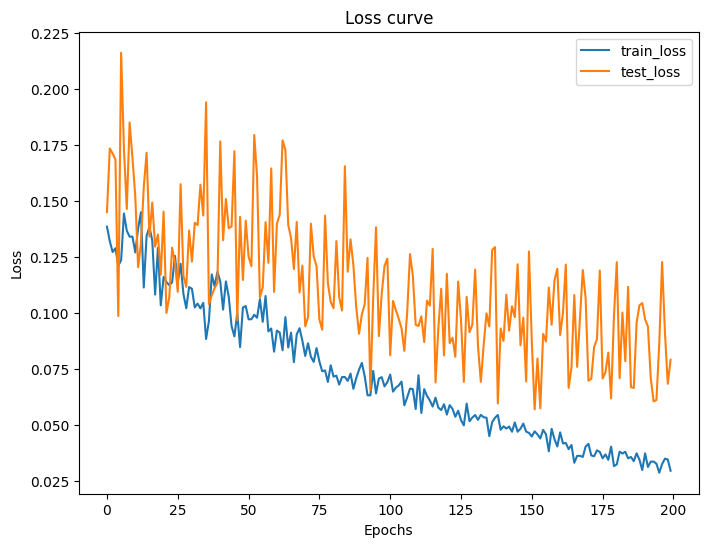

In [25]:
#parameters
learning_rate = 1e-4
epochs = 200
n_classes = 50
n_samples = 2
margin = 0.001

# device
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

# model
model = SymConvNet().to(device)

# dataloaders
train_batch_sampler = BalancedBatchSampler(y_train.tolist(), n_classes=n_classes, n_samples=n_samples)
test_batch_sampler = BalancedBatchSampler(y_test.tolist(), n_classes=n_classes, n_samples=n_samples)

triplets_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler)
triplets_test_loader = torch.utils.data.DataLoader(test_dataset, batch_sampler=test_batch_sampler)


# criterion
criterion = TripletLoss(margin,  RandomTripletSelector())

# optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=triplets_train_loader,
                  test_DataLoader=triplets_test_loader,
                  epochs=epochs)

# start training
trainer.run_trainer()

In [92]:
def query_generator(images, labels, n_queries, n_candidates):
  import numpy as np
  import random
  labels = labels.cpu().data.numpy()
  queries = []
  for label in set(labels):
    label_mask = (labels == label)
    label_indices = np.where(label_mask)[0]
    if len(label_indices) < 2:
        continue
    negative_indices = np.where(np.logical_not(label_mask))[0]
    anchor_positives = list(combinations(label_indices, 2))
    for anchor_positive in anchor_positives:
      anchor = anchor_positive[0]
      positive = anchor_positive[1]
      negatives = np.random.choice(negative_indices, size=n_candidates-1, replace=False)
      truth = np.random.randint(n_candidates)
      candidates = np.insert(negatives, truth, positive)
      queries.append([anchor, candidates, truth])
  sampled_queries = random.sample(queries, n_queries)
  anchor_images, candidates_images, truth = [],[],[]
  for sampled_query in sampled_queries:
    anchor_images.append(images[sampled_query[0]])
    temp_candidate_images = []
    for index in sampled_query[1]:
      temp_candidate_images.append(images[index])
    tensor_candidate_images = torch.stack(temp_candidate_images, 0)
    candidates_images.append(tensor_candidate_images)
    truth.append(sampled_query[2])
  return torch.stack(anchor_images, 0), torch.stack(candidates_images, 0), truth

In [107]:
# function to determine performance of model
def query_performance(model, queries, targets, truth, top=1):
  from scipy.spatial.distance import cdist
  assert top >= 1
  cnt = 0
  for i in range(len(truth)):
      q = queries[i][None].float().cuda()
      t = targets[i].float().cuda()

      with torch.no_grad():

          emb_q = model(q).cpu().numpy()
          emb_t = model(t).cpu().numpy()

          dists = cdist(emb_q, emb_t)

          if top == 1:
              pred = np.argmin(dists)

              if pred == truth[i]:
                  cnt += 1

          else:
              pred = np.argsort(dists)
              if truth[i] in pred[0,:top].tolist():
                  cnt+=1
  return (cnt/len(truth))

In [111]:
queries_tensor, targets_tensor, truth = query_generator(X_test, y_test, 50, 5)

In [112]:
print(query_performance(model, queries_tensor, targets_tensor, truth, top=1))
print(query_performance(model, queries_tensor, targets_tensor, truth, top=2))
print(query_performance(model, queries_tensor, targets_tensor, truth, top=3))
print(query_performance(model, queries_tensor, targets_tensor, truth, top=4))

0.24
0.5
0.66
0.78
